In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona

import shapely
from shapely.validation import make_valid


In [2]:
from general_functions import *

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
#define relative paths
waterschap = 'Rijnland'
path_Rijnland = '..\..\Data_preprocessed\Waterschappen\Rijnland\DataRijnland\DataRijnland.gpkg'
output_gpkg_path = "../../Data_postprocessed/Waterschappen/Rijnland"


In [42]:
Rijnland = read_gpkg_layers(gpkg_path = path_Rijnland, 
                        variables = ['stuw', 
                                     'gemaal', 
                                     'afsluitmiddel',
                                     'duikersifonhevel',
                                     'hydroobject',
                                     'peilgebiedvigerend',
                                     'peilgebiedpraktijk',
                                     'peilafwijkinggebied',
                                     'streefpeil']) 
                                     

# Rijnland

<AxesSubplot:>

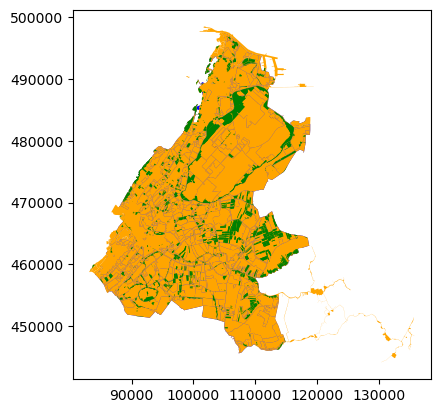

In [43]:
fig, ax = plt.subplots()
Rijnland['peilgebiedvigerend'].plot(ax=ax, color='blue')
Rijnland['peilgebiedpraktijk'].plot(ax=ax, color='orange')
Rijnland['peilafwijkinggebied'].plot(ax=ax, color='green')

In [44]:
Rijnland['stuw'] = Rijnland['stuw'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['gemaal'] = Rijnland['gemaal'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['afsluitmiddel'] = Rijnland['afsluitmiddel'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['hydroobject'] = Rijnland['hydroobject'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['duikersifonhevel'] = Rijnland['duikersifonhevel'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilgebiedpraktijk'] = Rijnland['peilgebiedpraktijk'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilafwijkinggebied'] = Rijnland['peilafwijkinggebied'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilgebiedvigerend'] = Rijnland['peilgebiedvigerend'][['code', 'nen3610id', 'globalid', 'geometry']]


In [45]:
#fix geometries
Rijnland['peilgebiedvigerend']['geometry'] = Rijnland['peilgebiedvigerend'].buffer(distance = 0)
Rijnland['peilgebiedpraktijk']['geometry'] = Rijnland['peilgebiedpraktijk'].buffer(distance = 0)
Rijnland['peilafwijkinggebied']['geometry'] = Rijnland['peilafwijkinggebied'].buffer(distance = 0)

C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

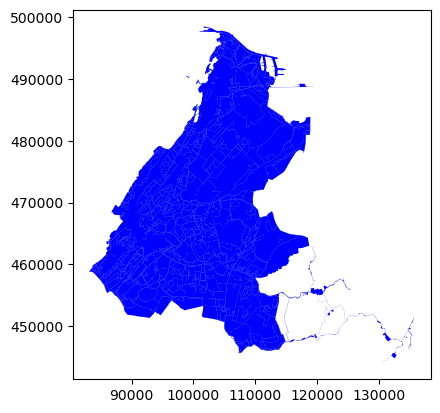

In [46]:
# peilgebied = burn_in_peilgebieden(base_layer = Rijnland['peilgebiedpraktijk'], 
#                                   overlay_layer = Rijnland['peilafwijkinggebied'],
#                                   plot = True)
# Rijnland['peilgebied'] = gpd.GeoDataFrame(peilgebied)

peilgebied = burn_in_peilgebieden(base_layer = Rijnland['peilgebiedvigerend'], 
                                  overlay_layer = Rijnland['peilgebiedpraktijk'],
                                  plot = True)


In [47]:
peilgebied = gpd.GeoDataFrame(peilgebied)
peilgebied = peilgebied[peilgebied.geometry.type.isin(['Polygon', 'MultiPolygon'])] #only select polygons

Rijnland['peilgebied'] = gpd.GeoDataFrame(peilgebied)

In [48]:
gpd.GeoDataFrame(peilgebied).to_file('Rijnland_test_kan_weg.shp')
# peilgebied

In [49]:
# # Explode the multipolygons into separate parts
# exploded_peilgebied = Rijnland['peilgebied'].explode('geometry')

# # Check if each part is a single polygon
# is_simple_polygon = exploded_peilgebied['geometry'].apply(lambda geom: geom.type == 'Polygon')

# # Select only the simple polygons from the exploded GeoDataFrame
# simple_peilgebied = exploded_peilgebied[is_simple_polygon]
# simple_peilgebied

In [50]:
# #convert multi polygon to single polygon
# Rijnland['peilgebied'] = Rijnland['peilgebied'].explode()
# Rijnland['peilgebied']['nen3610id'] = 'dummy_nen3610id_duikersifonhevel_' + Rijnland['peilgebied'].index.astype(str)


In [51]:
Rijnland['streefpeil'].peilgebiedpraktijkid.fillna(value=Rijnland['streefpeil']['peilgebiedvigerendid'], inplace=True)
# Rijnland['streefpeil'].drop_duplicates(subset=['peilgebiedpraktijkid'], inplace=True)

In [52]:
#get rid of irrelevant streefpeilen, which otherwise results in too many overlapped peilgebieden
filter_condition = Rijnland['streefpeil']['soortstreefpeil'].isin(['omer', 'ondergrens']) #'omer' for all rows where something of zomer, Zomer, dynamische zomer, etc, is used
kept_rows = Rijnland['streefpeil'][filter_condition]

other_rows = Rijnland['streefpeil'][~filter_condition].drop_duplicates(subset=['peilgebiedpraktijkid'])
Rijnland['streefpeil'] = pd.concat([kept_rows, other_rows])

In [53]:
# Rijnland['streefpeil'].peilafwijkinggebiedid.fillna(value=Rijnland['streefpeil']['peilgebiedpraktijkid'], inplace=True)
# Rijnland['streefpeil'].peilgebiedpraktijkid.fillna(value=Rijnland['streefpeil']['peilgebiedvigerendid'], inplace=True)

pg_sp = pd.merge(left = peilgebied,
                      right = Rijnland['streefpeil'],
                      left_on = 'globalid',
                      right_on = 'peilgebiedpraktijkid',
                      suffixes = ('', '_streefpeil'))

pg_sp['geometry'] = gpd.GeoDataFrame(geometry = pg_sp['geometry']).reset_index(drop=True)
# pg_sp = pg_sp.explode('geometry',ignore_index=True)

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_16304\371328050.py:10: UserWarning: Geometry column does not contain geometry.
  pg_sp['geometry'] = gpd.GeoDataFrame(geometry = pg_sp['geometry']).reset_index(drop=True)


In [54]:
# gpd.GeoDataFrame(pg_sp.loc[pg_sp.code != 'PBS_WW-25AS'], geometry='geometry').set_crs('EPSG:28992').to_file('peilgebieden_Rijnland.gpkg', driver='GPKG')

In [55]:
#there are duplicate codes, nen3610ids and globalids due to the exploded function. Rename these.
pg_sp['nen3610id'] = 'dummy_nen3610id_peilgebied_' + pg_sp.index.astype(str)
pg_sp['code'] = 'dummy_code_peilgebied_' + pg_sp.index.astype(str)
pg_sp['globalid'] = 'dummy_globalid_peilgebied_' + pg_sp.index.astype(str)

Rijnland['peilgebied'] = pg_sp
Rijnland['peilgebied'] = Rijnland['peilgebied'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilgebied'] = gpd.GeoDataFrame(Rijnland['peilgebied'], geometry = 'geometry')
Rijnland['peilgebied'] = Rijnland['peilgebied'].set_crs('EPSG:28992')

In [56]:
streefpeil = pg_sp[['waterhoogte', 'globalid']]

streefpeil['geometry'] = np.nan
streefpeil = gpd.GeoDataFrame(streefpeil)
Rijnland['streefpeil'] = streefpeil

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_16304\1567509723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streefpeil['geometry'] = np.nan


In [57]:
#delete irrelvant data
variables = ['peilgebiedpraktijk', 'peilgebiedvigerend', 'peilafwijkinggebied']

for variable in variables:
    if str(variable) in Rijnland:
        del Rijnland[variable]

<AxesSubplot:>

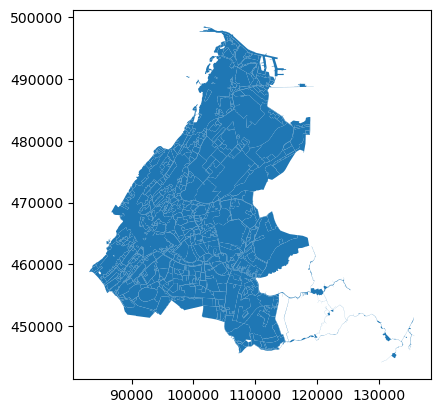

In [58]:
Rijnland['peilgebied'].plot()

### Check for the correct keys and columns

In [59]:
show_layers_and_columns(waterschap = Rijnland)

stuw
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

afsluitmiddel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  None

peilgebied
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992



### Store data

In [60]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = Rijnland, 
           output_gpkg_path = output_gpkg_path + '/Rijnland')
